<a href="https://colab.research.google.com/github/samarasimhareddymatla-sys/air-pollution-prediction/blob/main/Air_Quality_Prediction_%26_Pollution_Hotspot_Detection_week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Libraries**

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import joblib

from google.colab import files

**Uploading Dataset**

In [20]:
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

print("Dataset loaded successfully")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())

Saving hyderabad_air_quality_latest (3).csv to hyderabad_air_quality_latest (3).csv
Dataset loaded successfully
Shape: (81, 13)
Columns: ['city', 'station_name', 'station_id', 'sensor_id', 'sensor_name', 'parameter', 'value', 'units', 'datetime_utc', 'datetime_local', 'latitude', 'longitude', 'timezone']
  city                                 station_name  station_id  sensor_id  \
0  NaN  Bollaram Industrial Area, Hyderabad - TSPCB        5599   12235395   
1  NaN  Bollaram Industrial Area, Hyderabad - TSPCB        5599   12235396   
2  NaN  Bollaram Industrial Area, Hyderabad - TSPCB        5599   12235397   
3  NaN  Bollaram Industrial Area, Hyderabad - TSPCB        5599   12235398   
4  NaN  Bollaram Industrial Area, Hyderabad - TSPCB        5599   12235399   

  sensor_name parameter  value  units          datetime_utc  \
0      co ppb        co   0.48    ppb  2025-09-13T02:15:00Z   
1      no ppb        no  10.40    ppb  2025-09-13T02:15:00Z   
2     no2 ppb       no2  22.20    pp

**Pre-Processing**

In [21]:
if "value" in df.columns:
    df.rename(columns={"value": "PM2.5"}, inplace=True)

# Convert numeric columns properly
for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Fill missing values with column means
df = df.fillna(df.mean(numeric_only=True))
print("Shape after cleaning:", df.shape)
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["hour"] = df["date"].dt.hour
    df["day"] = df["date"].dt.day
    df["month"] = df["date"].dt.month
    df["PM2.5_roll_mean"] = df["PM2.5"].rolling(window=3, min_periods=1).mean()

Shape after cleaning: (81, 13)


**EDA**

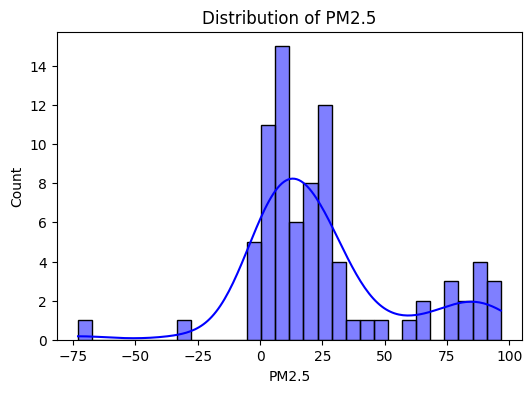

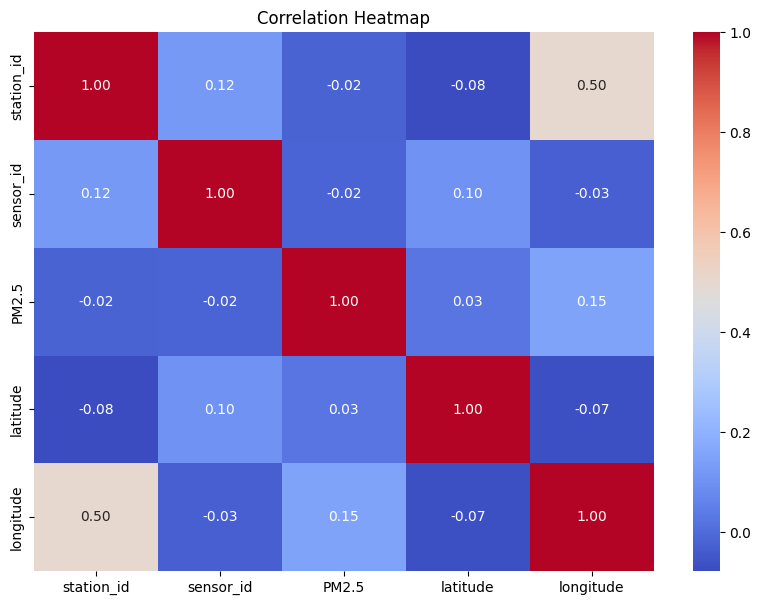

In [22]:
plt.figure(figsize=(6,4))
sns.histplot(df["PM2.5"], bins=30, kde=True, color="blue")
plt.title("Distribution of PM2.5")
plt.show()

plt.figure(figsize=(10,7))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

**Feautres and Target**



In [23]:
# 📌 6. Features & Target
X = df.drop("PM2.5", axis=1).select_dtypes(include=[np.number])
y = df["PM2.5"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Feature Shape:", X.shape, "Target Shape:", y.shape)

Feature Shape: (81, 4) Target Shape: (81,)


**Train-Test Split**

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

**Train Models**

In [25]:
# Linear Regression
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# XGBoost
xgb_model = XGBRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

**Evaluate Models**

In [26]:
def evaluate_model(name, y_true, y_pred):
    return {
        "Model": name,
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2 Score": r2_score(y_true, y_pred),
    }

results = [
    evaluate_model("Linear Regression", y_test, y_pred_lin),
    evaluate_model("Random Forest", y_test, y_pred_rf),
    evaluate_model("XGBoost", y_test, y_pred_xgb),
]

results_df = pd.DataFrame(results)
print("\nModel comparison:")
print(results_df)


Model comparison:
               Model          MSE        MAE  R2 Score
0  Linear Regression   788.975143  19.585313 -0.105712
1      Random Forest   772.230225  22.269374 -0.082245
2            XGBoost  1110.315754  25.840319 -0.556056


**Visualization of Predictions**

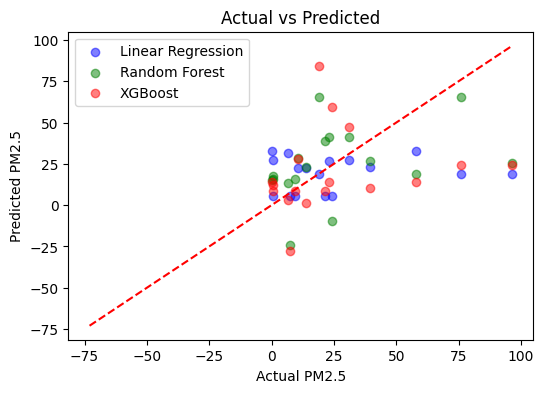

In [27]:
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred_lin, alpha=0.5, label="Linear Regression", color="blue")
plt.scatter(y_test, y_pred_rf, alpha=0.5, label="Random Forest", color="green")
plt.scatter(y_test, y_pred_xgb, alpha=0.5, label="XGBoost", color="red")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--")
plt.xlabel("Actual PM2.5")
plt.ylabel("Predicted PM2.5")
plt.legend()
plt.title("Actual vs Predicted")
plt.show()

**Save Best model & prediction Function**

In [28]:
best_model = None
best_r2 = -np.inf

for model, pred in [
    ("Linear Regression", y_pred_lin),
    ("Random Forest", y_pred_rf),
    ("XGBoost", y_pred_xgb),
]:
    r2 = r2_score(y_test, pred)
    if r2 > best_r2:
        best_r2 = r2
        best_model = {
            "Linear Regression": lin_model,
            "Random Forest": rf_model,
            "XGBoost": xgb_model,
        }[model]
joblib.dump(best_model, "best_model.pkl")
print("\nBest model saved as best_model.pkl with R²:", best_r2)
def predict_pm25(new_data):
    """Predict PM2.5 for new data (expects dataframe with same features)."""
    model = joblib.load("best_model.pkl")
    return model.predict(new_data)
print("Sample predictions:", predict_pm25(X_test[:5]))


Best model saved as best_model.pkl with R²: -0.0822446596218962
Sample predictions: [15.878  17.6445 18.7022 38.998  15.1926]
